The initial Input is the SAP lightcurve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import scipy.signal as sig
import fourier_analysis as fa

<IPython.core.display.Javascript object>


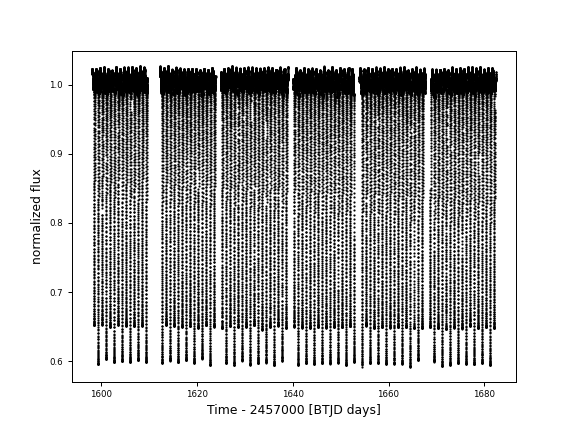

In [2]:
%matplotlib notebook
endurance_dir = 'endurance'
original_lc = np.loadtxt(f'{endurance_dir}/RS_Cha_lightcurve.txt').T
time = original_lc[0]
flux = original_lc[1]
fig, ax = plt.subplots()
ax.plot(time, flux, 'ko', ms = 0.75)
ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('normalized flux')
plt.show()

We then run the nelder mead algorithm in aggressive mode on a third of the lightcurve for 1000 iterations. The best fitting model results in:

<IPython.core.display.Javascript object>


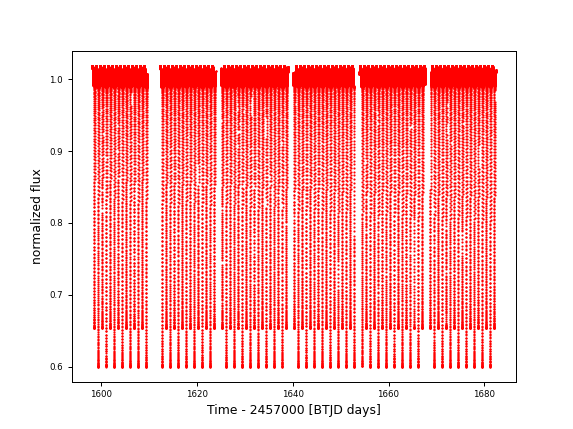

In [3]:
mod = np.loadtxt(f'{endurance_dir}/lets_try_a_third_of_the_lightcurve/binary_model.txt').T
mod_time = mod[0]
mod_flux = mod[1]
fig, ax = plt.subplots()
ax.plot(time, mod_flux, 'ro', ms = 0.75)
ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('normalized flux')
plt.show()

We then calculate the residuals. This gives

<IPython.core.display.Javascript object>


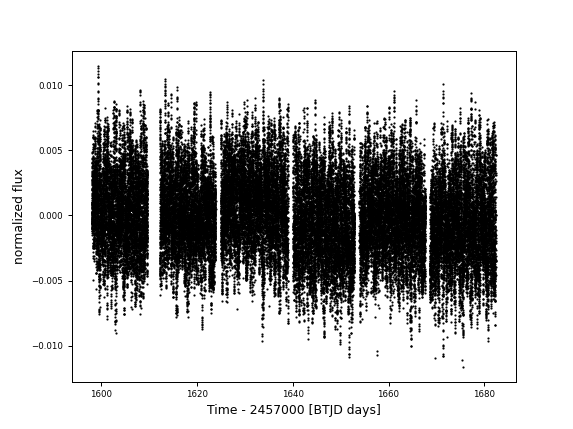

In [4]:

res = flux - mod_flux
fig, ax = plt.subplots()
ax.plot(time, res, 'ko', ms = 0.75)
ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('normalized flux')
plt.show()

/Users/thomas/Documents/Projects/RS_Cha/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


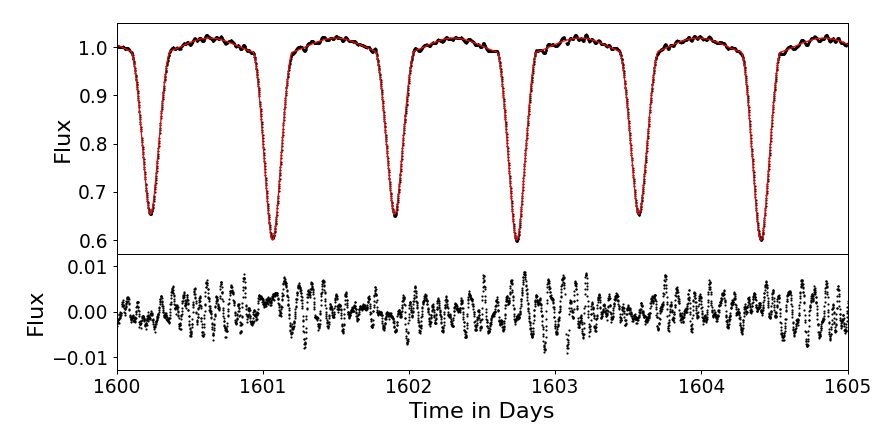

/Users/thomas/Documents/Projects/RS_Cha/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  app.launch_new_instance()


In [22]:

plt.rcParams.update({'font.size': 18, 'xtick.labelsize': 'small', 'ytick.labelsize': 'small',})
fig= plt.figure(constrained_layout=True, figsize = (10,5))
gs = fig.add_gridspec(9, 1)
ax2 = fig.add_subplot(gs[0:-3, 0])
ax4 = fig.add_subplot(gs[-3:, 0])

ax2.plot(time, flux, 'ko', ms = 0.75)
ax2.plot(time, mod_flux, 'r-', lw = 1)
ax4.plot(time, res, 'ko', ms = 0.75)
ax2.set_xlim([1600, 1605])
ax4.set_xlim([1600, 1605])
ax2.set_xticks([])
ax4.set_xlabel('Time in Days')
ax2.set_ylabel('Flux')
ax4.set_ylabel('Flux')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('RS_Cha_master_thesis.png', bbox_inches = 0)

We now see some unwanted (very) low frequency trend. We use a Savgol filter to remove it. The savgol will gives

<IPython.core.display.Javascript object>


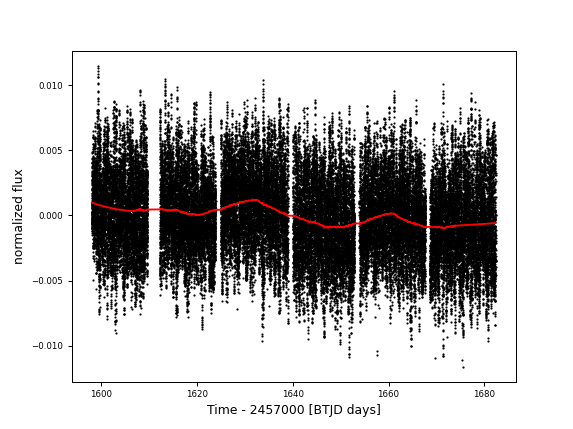

Text(0, 0.5, 'normalized flux')

In [5]:
fig, ax = plt.subplots()
smooth = sig.savgol_filter(res, 12001, 2)
ax.plot(time, res, 'ko', ms = 0.75)
ax.plot(time, smooth , 'r-')
ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('normalized flux')

<IPython.core.display.Javascript object>


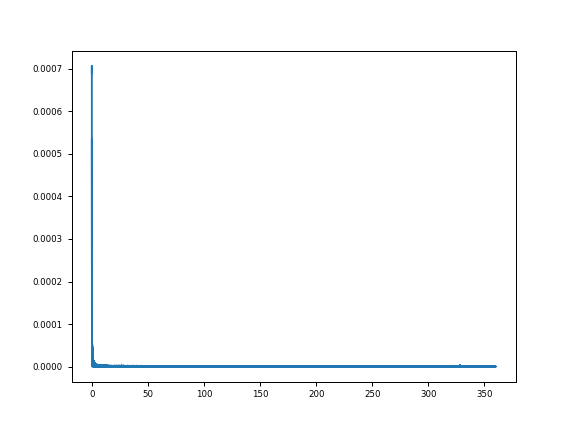

In [6]:
s = lk.LightCurve(time, smooth).to_periodogram()
fig, ax = plt.subplots()
ax.plot(s.frequency,s.power)


With this trend removed we find our lightcurve to be 

<IPython.core.display.Javascript object>


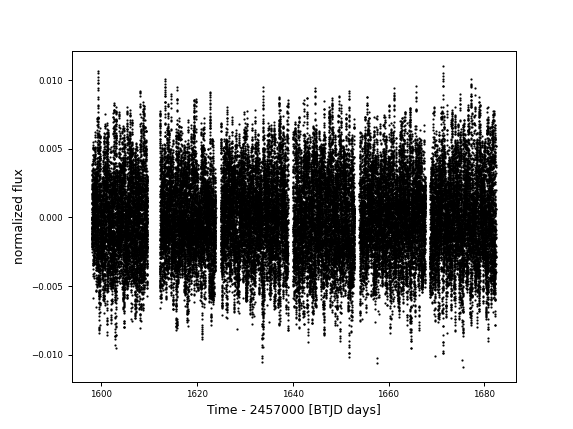

In [7]:
puls_lc = res - smooth
fig, ax = plt.subplots()
ax.plot(time, puls_lc, 'ko', ms = 0.75)
ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('normalized flux')
#np.savetxt(f'{endurance_dir}/Removed_Binary_plus_savgol_from_original.txt', np.array([time, puls_lc]).T)
plt.show()

<IPython.core.display.Javascript object>


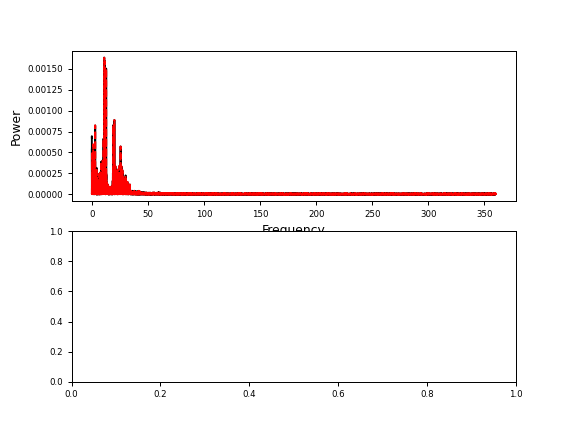

Text(0, 0.5, 'Power')

In [8]:
test1 = lk.LightCurve(time, res).to_periodogram()
test2 = lk.LightCurve(time, puls_lc).to_periodogram()
fig, a = plt.subplots(2,1)
ax = a[0]
ax.plot(test1.frequency, test1.power, 'k-')
ax.plot(test2.frequency, test2.power, 'r--')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')


We let smurfs run on that lightcurve. The resulting frequencies are a lot. We now have 3 classes of frequencies:
- Frequencies that are multiples of the binary frequency (Most probable from not ideal Model)
- Frequencies that are very close to already found frequencies and very low frequencies ( ~ rayleigh limit, < 0.25)
- All other frequencies are probably pulsations

In [9]:
ftr, fb, frl = fa.get_freqs_to_remove(f'{endurance_dir}/Removed_Binary_plus_savgol_from_original/', plot = False)

endurance/Removed_Binary_plus_savgol_from_original/data/results.csv


Using all this frequencies to generate a model we would find 

<IPython.core.display.Javascript object>


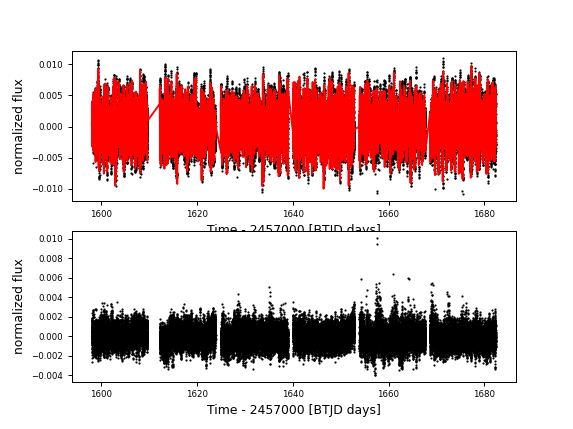

In [10]:
all_f_mod = np.zeros(len(time))
for f in ftr:
    all_f_mod = all_f_mod + fa.fourier_model(time, [f.f], [f.amp], [f.phase])
for f in fb:
    all_f_mod = all_f_mod + fa.fourier_model(time, [f.f], [f.amp], [f.phase])
for f in frl:
    all_f_mod = all_f_mod + fa.fourier_model(time, [f.f], [f.amp], [f.phase])
    
fig, ax = plt.subplots(2,1)
ax[0].plot(time, puls_lc, 'ko', ms = 0.75)
ax[0].plot(time, all_f_mod, 'r-')
ax[1].plot(time, all_f_mod - puls_lc, 'ko', ms = 0.75)
for a in ax:
    a.set_xlabel('Time - 2457000 [BTJD days]')
    a.set_ylabel('normalized flux')


If we on the other hand dont use the multiples of the binary frequency we arrive at

<IPython.core.display.Javascript object>


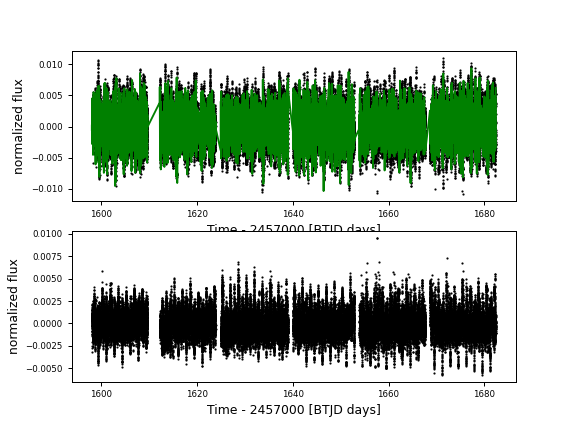

In [13]:
all_bb_f_mod = np.zeros(len(time))
for f in ftr:
    all_bb_f_mod = all_bb_f_mod + fa.fourier_model(time, [f.f], [f.amp], [f.phase])
for f in frl:
    all_bb_f_mod = all_bb_f_mod + fa.fourier_model(time, [f.f], [f.amp], [f.phase])
    
fig, ax = plt.subplots(2,1)
ax[0].plot(time, puls_lc, 'ko', ms = 0.75)
ax[0].plot(time, all_bb_f_mod, 'g-')
ax[1].plot(time, all_bb_f_mod - puls_lc, 'ko', ms = 0.75)
for a in ax:
    a.set_xlabel('Time - 2457000 [BTJD days]')
    a.set_ylabel('normalized flux')


<IPython.core.display.Javascript object>


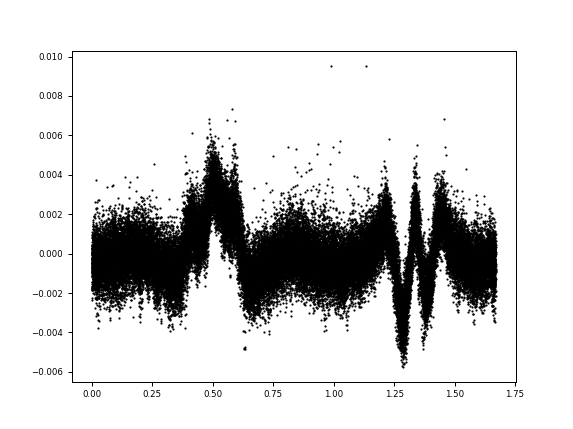

In [16]:

fig, ax = plt.subplots()
ax.plot(time%(1/0.5988495842998753), all_bb_f_mod - puls_lc, 'ko', ms = 0.75)


This gives us a clear hint that, infact the the binary model is not perfect. We now remove the pulsation signal as well as the savgol smooth from the original lightcurve.

<IPython.core.display.Javascript object>


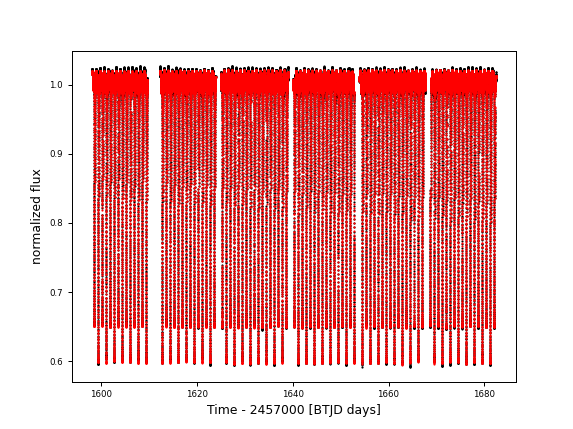

In [17]:

fig, ax = plt.subplots()
ax.plot(time, flux, 'ko', ms = 0.75)
new_lc = lk.LightCurve(time, flux - smooth-all_bb_f_mod)
new_lc.normalize()
ax.plot(new_lc.time, new_lc.flux, 'ro', ms = 0.75)
ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('normalized flux')
plt.show()

While the out of eclipse phase still shows some variations, it is way cleaner than in the original lc. We therefore use this lightcurve as new input for an optimization run.

In [20]:
np.savetxt(f'{endurance_dir}/Removed_Pulsations_from_first_run.txt', np.array([time, flux-smooth-all_bb_f_mod]).T)

De difference to the model still shows some variation. This is also what we saw in the smurfs result - the multiples of the orbital frequency.

<IPython.core.display.Javascript object>


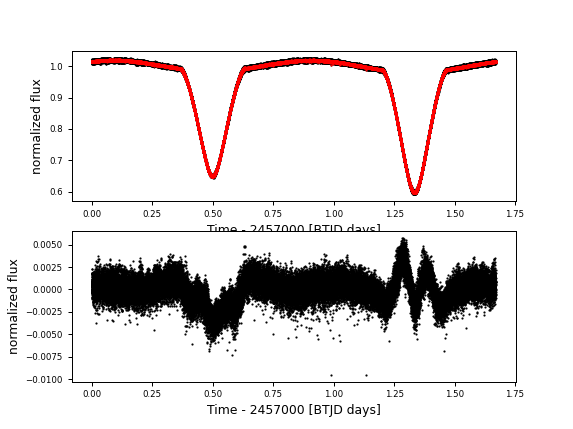

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(time%(1/0.5988495842998753), flux, 'ko', ms = 0.75)
ax[0].plot(new_lc.time%(1/0.5988495842998753), new_lc.flux, 'ro', ms = 0.75)
ax[1].plot(new_lc.time%(1/0.5988495842998753), new_lc.flux - mod_flux, 'ko', ms = 0.75)
for a in ax:
    a.set_xlabel('Time - 2457000 [BTJD days]')
    a.set_ylabel('normalized flux')
plt.show()

<IPython.core.display.Javascript object>


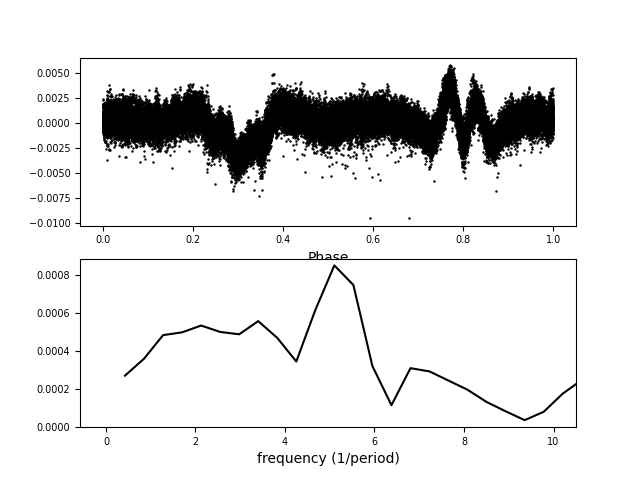

Text(0.5, 0, 'frequency (1/period)')

In [57]:
fig, ax = plt.subplots(2,1)

resid_phased = lk.LightCurve(new_lc.time%(1/0.5988495842998753)/(1/0.5988495842998753), new_lc.flux - mod_flux).to_periodogram()
ax[0].plot(new_lc.time%(1/0.5988495842998753)/(1/0.5988495842998753), new_lc.flux - mod_flux, 'ko', ms = 0.75)
ax[1].plot(resid_phased.frequency, resid_phased.power, 'k-')
ax[0].set_xlabel('Phase')
ax[1].set_xlabel('frequency (1/period)')

<IPython.core.display.Javascript object>


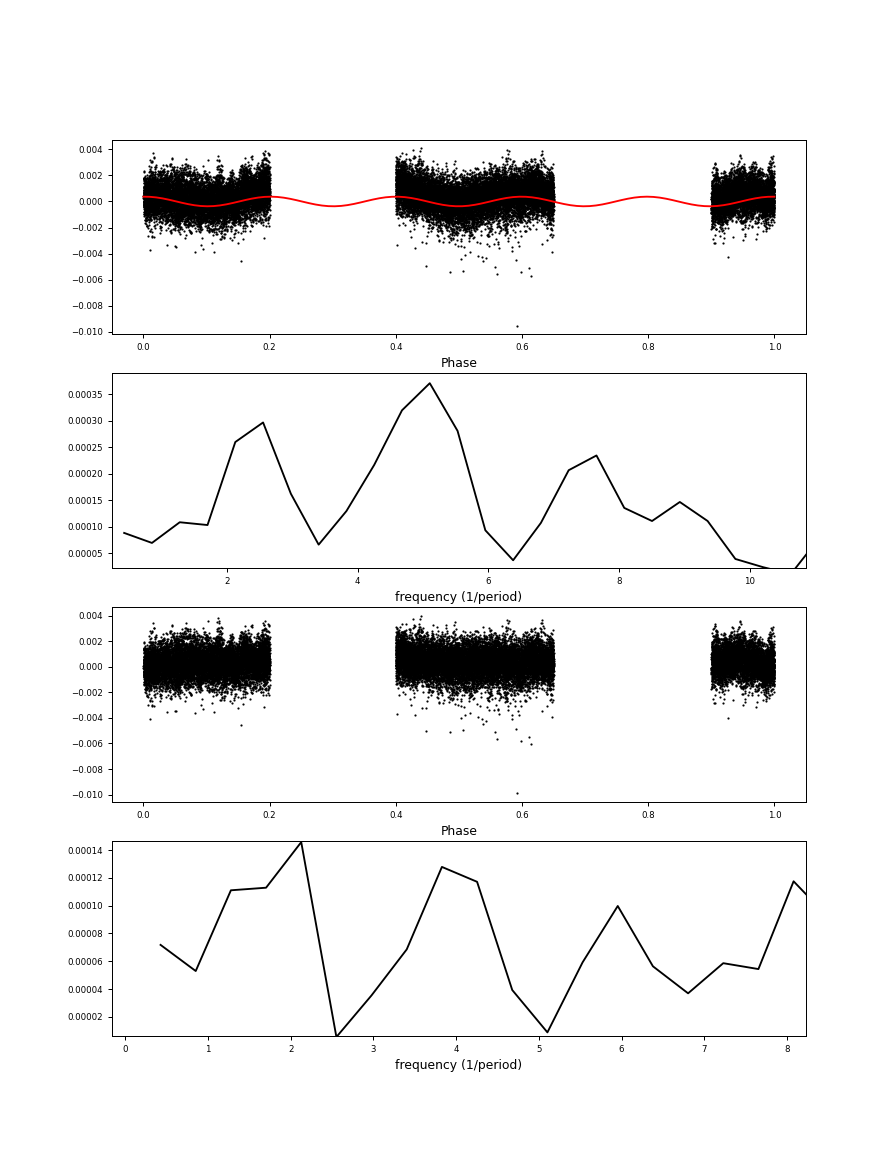

0.00037331265709685647
0.00036927482761918076 5.028520943766968 0.23747030466672983
8.396968246451891


Text(0.5, 0, 'frequency (1/period)')

In [55]:
fig, ax = plt.subplots(4,1, figsize = (10,13))
time_rsid = new_lc.time%(1/0.5988495842998753)/(1/0.5988495842998753)
se = np.where(np.logical_and(abs(time_rsid - 0.3) >= 0.1, abs(time_rsid - 0.775) >= 0.125))
print(np.mean(new_lc.flux[se] - mod_flux[se]))
resid_phased = lk.LightCurve(time_rsid[se], new_lc.flux[se] - mod_flux[se] - np.mean(new_lc.flux[se] - mod_flux[se]))
resid_phased_pdg = resid_phased.to_periodogram()
ax[0].plot(time_rsid[se], new_lc.flux[se] - mod_flux[se], 'ko', ms = 0.75)
ax[1].plot(resid_phased_pdg.frequency, resid_phased_pdg.power, 'k-')
funny = _scipy_fit(resid_phased, [mode(5, 0.00035, 0.5, 10)])
ax[0].plot(np.linspace(0,1, 100), sin(np.linspace(0,1, 100), funny[0].amp.n, funny[0].f.n, funny[0].phase.n), 'r-')
print(funny[0].amp.n, funny[0].f.n, funny[0].phase.n)
print(funny[0].f.n/0.5988495842998753)
resid_phased2pdg = lk.LightCurve(time_rsid[se], new_lc.flux[se] - mod_flux[se]- sin(time_rsid[se], funny[0].amp.n, funny[0].f.n, funny[0].phase.n)).to_periodogram()


ax[3].plot(resid_phased2pdg.frequency, resid_phased2pdg.power, 'k-')
ax[2].plot(time_rsid[se], new_lc.flux[se] - mod_flux[se]- sin(time_rsid[se], funny[0].amp.n, funny[0].f.n, funny[0].phase.n), 'ko', ms = 0.75)

ax[0].set_xlabel('Phase')
ax[1].set_xlabel('frequency (1/period)')
ax[2].set_xlabel('Phase')
ax[3].set_xlabel('frequency (1/period)')

Binning the lightcurve helps

In [14]:
def binning(time, mag, period):
    time = (time%period)/period# (1/0.5988495842998753)*0.5988495842998753
    bins = []
    means = []
    sds = []
    num = 250
    bins.append(0)
    ind = np.where(np.logical_and(time >= 0, time <= 0.5 / num))
    means.append(np.mean(mag[ind]))
    sds.append(np.std(mag[ind]))
    for i in range(num - 1):
        ind = np.where(np.logical_and(time >= (i + 0.5) / num, time <= (i + 1.5) / num))
        if ind[0].size > 0:
            bins.append((i + 1) / num)
            means.append(np.mean(mag[ind]))
            sds.append(np.std(mag[ind]))
    bins.append(1)
    ind = np.where(np.logical_and(time >= (num - 0.5) / num, time <= 1))
    means.append(np.mean(mag[ind]))
    sds.append(np.std(mag[ind]))
    return bins, means, sds

<IPython.core.display.Javascript object>


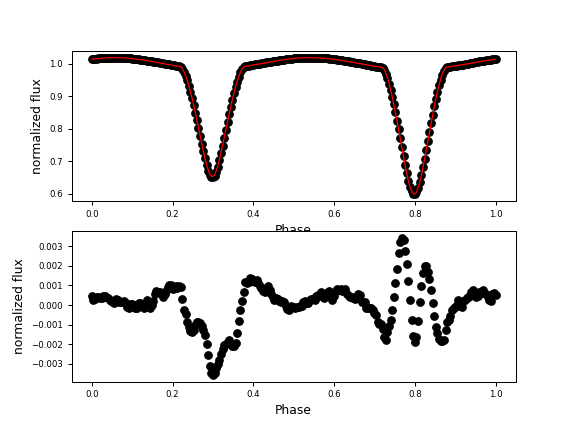

In [15]:
fig, ax = plt.subplots(2,1)
bins, means, sds = binning(time, new_lc.flux, 1/0.5988495842998753)
ax[0].plot(bins, means, 'ko')
bins, means, sds = binning(time, new_lc.flux- mod_flux, 1/0.5988495842998753)
time_folded = time%(1/0.5988495842998753)*0.5988495842998753
sort = np.argsort(time_folded)
ax[0].plot(time_folded[sort], mod_flux[sort], 'r-', lw = 1)
ax[1].plot(bins, means, 'ko')
for a in ax:
    a.set_xlabel('Phase')
    a.set_ylabel('normalized flux')
plt.show()

Lets check for any apsidal motion from a possible third component

We cant find shit. this is not surprising as the orbit is circular

Lets have a look at the resulting binary LC in the second iteration

<IPython.core.display.Javascript object>


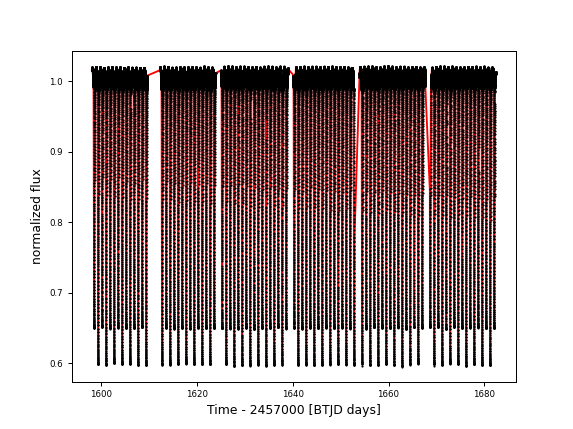

In [16]:
mod_it2= np.loadtxt(f'{endurance_dir}/Removed_Pulsations_from_first_run_irrad_gravbol/binary_model.txt').T
mod_it2_time = mod_it2[0]
mod_it2_flux = mod_it2[1]
it1_result = np.loadtxt(f'{endurance_dir}/Removed_Pulsations_from_first_run.txt').T
it1_time = it1_result[0]
it1_flux = it1_result[1]
fig, ax = plt.subplots()
ax.plot(time, mod_it2_flux, 'r', ms = 0.75)
ax.plot(time, it1_flux, 'ko', ms = 0.75)
ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('normalized flux')
plt.show()

and the residuals binned

<IPython.core.display.Javascript object>


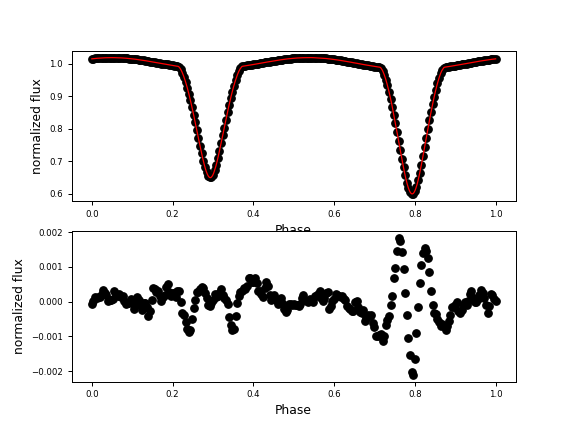

In [17]:
fig, ax = plt.subplots(2,1)
bins, means, sds = binning(time, it1_flux, 1.66987725)
ax[0].plot(bins, means, 'ko')
bins, means, sds = binning(time, it1_flux- mod_it2_flux, 1.66987725)
ax[1].plot(bins, means, 'ko')
time_folded = (time%1.66987725)/1.66987725
sort = np.argsort(time_folded)
ax[0].plot(time_folded[sort], mod_it2_flux[sort], 'r-', lw = 1)
for a in ax:
    a.set_xlabel('Phase')
    a.set_ylabel('normalized flux')
plt.show()

Indeed, the residuals look better. Yet there is still something periodic in it. To remove this signal as well, we Fit the first 30 harmonics of the orbital frequency to the residuals

In [32]:
from scipy.optimize import curve_fit
from uncertainties import ufloat

def _scipy_fit(lc, result):
    """
    Performs a combination fit for all found frequencies using *scipy.optimize.curve_fit*.

    :param result: List of found frequencies
    :return: List of improved frequencies
    """
    arr = []
    boundaries = [[], []]
    for r in result:
        arr.append(r.amp)
        arr.append(r.f)
        arr.append(r.phase)

    try:
        popt, pcov = curve_fit(sin_multiple, lc.time, lc.flux, p0=arr)
    except RuntimeError:
        print(f"Failed to improve first {len(result)} frequencies. Skipping fit improvement.")
        return result
    perr = np.sqrt(np.diag(pcov))
    for r, vals in zip(result,
                       [[ufloat(popt[i + j], perr[i + j]) for j in range(0, 3)] for i in range(0, len(popt), 3)]):
        r.amp = vals[0]
        r.f = vals[1]
        r.phase = vals[2]
        #print(r.amp, r.f, r.phase)
    return result


def sin_multiple(x: np.ndarray, *params) -> np.ndarray:
    """
    Multiple sinuses summed up

    :param x: Time axis
    :param params: Params, see *sin* for signature
    """
    y = np.zeros(len(x))
    for i in range(0, len(params), 3):
        y += sin(x, params[i], params[i + 1], params[i + 2])

    return y


def sin(x: np.ndarray, amp: float, f: float, phase: float) -> np.ndarray:
    """
    Sinus function, used for fitting.

    :param x: Time axis, days
    :param amp: amplitude, mag
    :param f: frequency, c/d
    :param phase: phase, normed to 1
    """
    return amp * np.sin(2. * np.pi * (f * x + phase))

class mode():
    def __init__(self, f, amp, phase, snr):
        self.f = f
        self.amp = amp
        self.phase = phase
        self.snr = snr

In [19]:
period = 1.66987725
f = 1/period
it2_resid = lk.LightCurve(mod_it2_time, it1_flux - mod_it2_flux)
fit_init = []
for i in range(1, 30):
    fit_init.append(mode(f*i, 0.0002, 0.5, 10))
fit = _scipy_fit(it2_resid, fit_init)

<IPython.core.display.Javascript object>


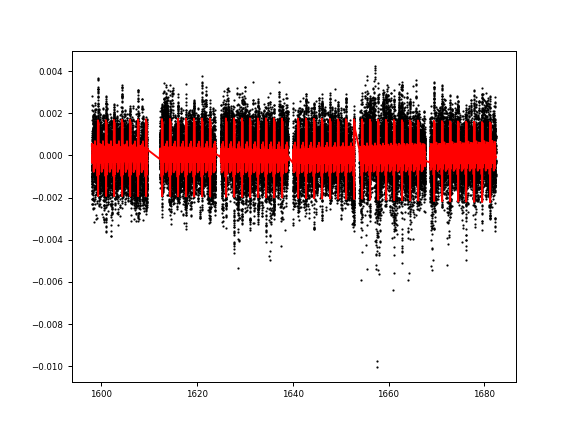

1.0012+/-0.0006 -0.000110+/-0.000006 -0.7+/-0.5
1.9989+/-0.0006 (9.5+/-0.6)e-05 1.4+/-0.6
3.0019+/-0.0009 (-6.7+/-0.6)e-05 -1.5+/-0.9
3.9942+/-0.0008 (-7.2+/-0.6)e-05 6.3+/-0.8
4.99969+/-0.00031 0.000194+/-0.000006 0.59+/-0.31
6.0071+/-0.0005 0.000132+/-0.000006 -6.3+/-0.4
6.9974+/-0.0015 (-4.0+/-0.6)e-05 3.2+/-1.5
7.9917+/-0.0006 -0.000109+/-0.000006 8.5+/-0.5
9.00010+/-0.00028 0.000215+/-0.000006 0.50+/-0.28
9.9963+/-0.0007 (-9.0+/-0.6)e-05 2.9+/-0.7
10.99952+/-0.00025 -0.000244+/-0.000006 1.00+/-0.24
12.00052+/-0.00033 0.000184+/-0.000006 0.71+/-0.32
12.99979+/-0.00028 0.000218+/-0.000006 0.64+/-0.27
13.99738+/-0.00024 0.000255+/-0.000006 3.24+/-0.23
14.9989+/-0.0004 -0.000168+/-0.000006 1.42+/-0.35
16.00110+/-0.00024 -0.000251+/-0.000006 -0.52+/-0.24
17.0016+/-0.0008 (7.4+/-0.6)e-05 -1.3+/-0.8
18.00127+/-0.00032 0.000191+/-0.000006 -0.81+/-0.31
19.0038+/-0.0015 (4.1+/-0.6)e-05 -3.0+/-1.4
19.9972+/-0.0004 -0.000156+/-0.000006 3.2+/-0.4
20.9981+/-0.0017 (-3.5+/-0.6)e-05 2.5+/-1.7
21.

In [20]:
fig, ax = plt.subplots()
for r in fit:
    print(r.f/f,r.amp, r.phase )
mod_fourier_b = np.zeros(len(it2_resid.time))
for r in fit:
    mod_fourier_b += sin(it2_resid.time, r.amp.n, r.f.n, r.phase.n)
ax.plot(it2_resid.time, it2_resid.flux, 'ko', ms = 0.75)
ax.plot(it2_resid.time, mod_fourier_b, 'r-')

<IPython.core.display.Javascript object>


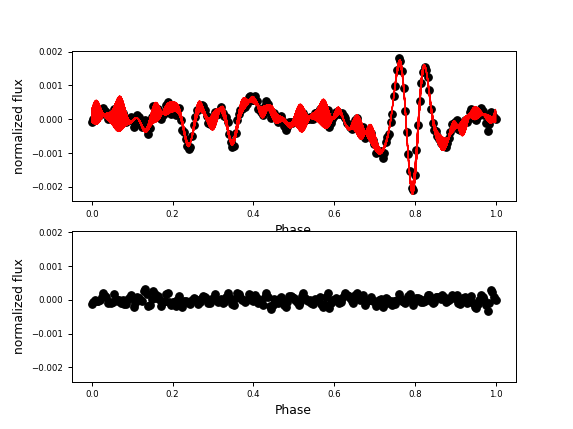

In [21]:
fig, ax = plt.subplots(2,1)
bins, means, sds = binning(time, it2_resid.flux, 1.66987725)
ax[0].plot(bins, means, 'ko')
bins, means, sds = binning(time, it2_resid.flux - mod_fourier_b, 1.66987725)
ax[1].plot(bins, means, 'ko')
time_folded = (time%1.66987725)/1.66987725
sort = np.argsort(time_folded)
ax[0].plot(time_folded[sort], mod_fourier_b[sort], 'r-', lw = 1)
for a in ax:
    a.set_xlabel('Phase')
    a.set_ylabel('normalized flux')
ax[1].set_ylim(ax[0].set_ylim())
plt.show()
np.savetxt(f'{endurance_dir}/Fourier_residual_model.txt', np.array([time, mod_fourier_b]).T)

As we can see above, this removes the reminder of any periodic signal. As we can not find any more p-mode frequencies, a third iteraion is not needed. We can start to create our final pulsation lightcurve. For this we take the original lc and remove the binary model from iteration 2. There are again low frequency thingies that we remove with a sacgol filter.

<IPython.core.display.Javascript object>


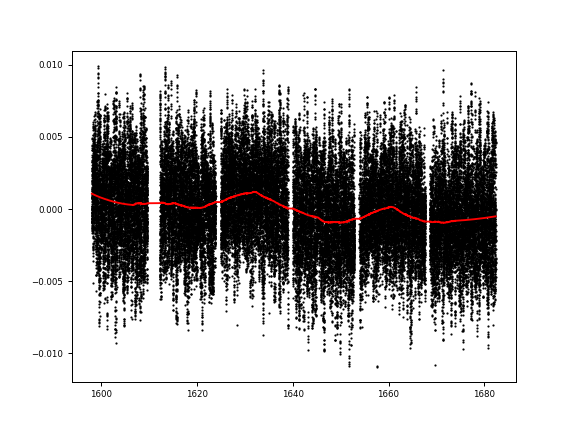

In [22]:
final_puls_f = flux- mod_it2_flux
fig, ax = plt.subplots()
ax.plot(time, final_puls_f , 'ko', ms = 0.75)
smooth = sig.savgol_filter(final_puls_f , 12001, 2)
ax.plot(time, smooth, 'r-')

We will also have to remove the fourier model for the remaining binary signal

<IPython.core.display.Javascript object>


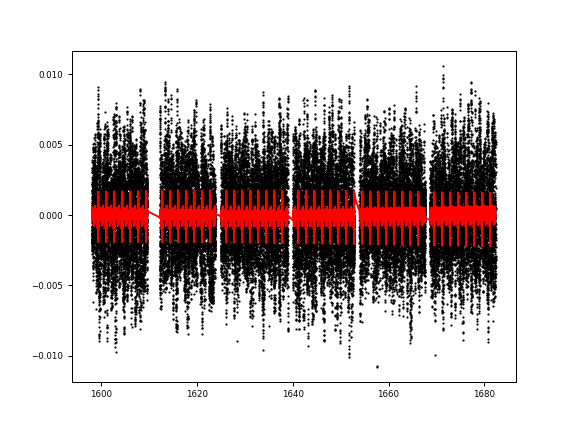

In [23]:
fig, ax = plt.subplots()
ax.plot(time, final_puls_f-smooth , 'ko', ms = 0.75)
ax.plot(time, mod_fourier_b, 'r-')

The final lightcurve looks like this:


<IPython.core.display.Javascript object>


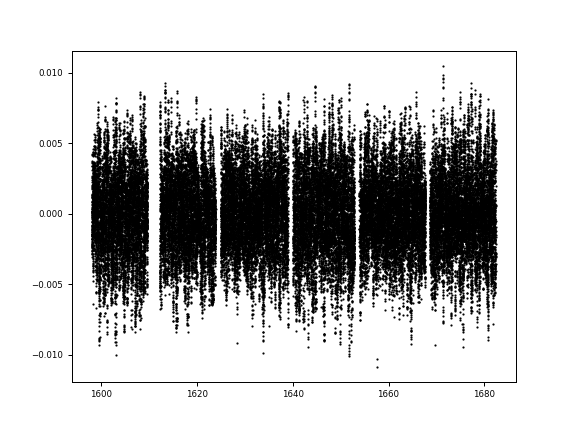

In [24]:
fig, ax = plt.subplots()
final_puls = lk.LightCurve(time,final_puls_f-smooth - mod_fourier_b)
ax.plot(final_puls.time, final_puls.flux, 'ko', ms = 0.75)



<IPython.core.display.Javascript object>


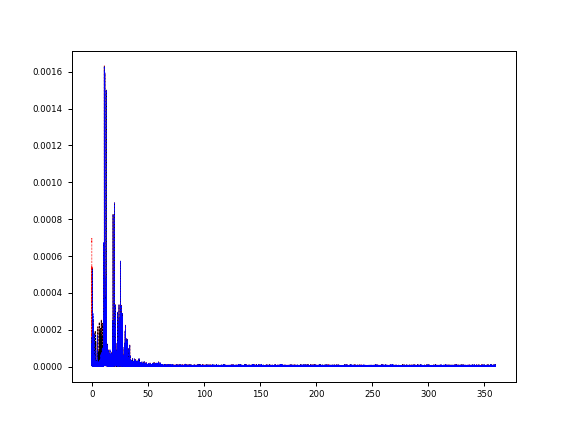

In [25]:
fig, ax = plt.subplots()
wos = lk.LightCurve(time,final_puls_f).to_periodogram()
w = lk.LightCurve(time,final_puls_f-smooth).to_periodogram()
wo = lk.LightCurve(time,final_puls_f-smooth - mod_fourier_b).to_periodogram()
ax.plot(wos.frequency, wos.power, 'r--', lw = 0.5)
ax.plot(w.frequency, w.power, 'k--', lw = 0.5)
ax.plot(wo.frequency, wo.power, 'b--', lw = 0.5)



Comparing the amplitude spectra, we still see some peaks at doubles of the orbital frequency. This might be due to a missing secondary eclipse, but what do I know. Lets have another look at the out of eclipse timestemps:


<IPython.core.display.Javascript object>


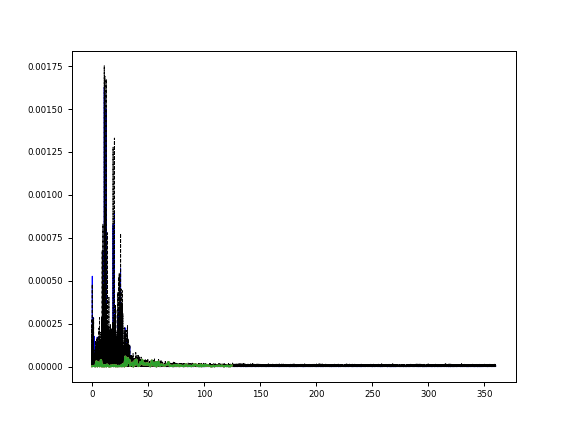

In [26]:
period = 1.66987725
ind = np.where(np.logical_and(abs(time % period / period - 0.3) >= 0.1, abs(time % period / period - 0.8) >= 0.1))
final_ooe = lk.LightCurve(final_puls.time[ind], final_puls.flux[ind]).to_periodogram()
fig, ax = plt.subplots()
ax.plot(wo.frequency, wo.power, 'b-', lw = 0.75)
ax.plot(final_ooe.frequency, final_ooe.power, 'k--', lw = 0.75)

In [27]:
#final_puls.normalize()
np.savetxt(f'{endurance_dir}/Final_Pulsation_LC.txt', np.array([final_puls.time, final_puls.flux]).T)